Average contig length: 484
Median contig length: 223


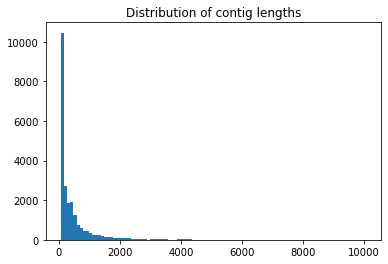

In [4]:
#generate histogram of assembly lengths
from os import listdir
from os.path import isfile, splitext, join
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from collections import Counter
from matplotlib import cm
from scipy.stats import fisher_exact
from os import  chdir,  listdir
from os.path import  isfile, join, splitext
import hdbscan
from Bio import SeqIO
import random
wd="/mnt/storage5/anton/Mosquitoes/DENV/InputData/"
#assembliesDir="/mnt/storage5/anton/Mosquitoes/DENV/assemblies/"
#files=[f for f in listdir(assembliesDir) if isfile(join(assembliesDir, f)) and splitext(f)[1]==".fasta"]

contigLengths=[]
contigSequences={}
for contig in SeqIO.parse(wd+"allAssemblies.fasta", "fasta"):
    contigLengths.append(len(contig.seq))
    contigSequences[contig.id]=str(contig.seq)


print("Average contig length: "+str(int(np.average(contigLengths))))
print("Median contig length: "+str(int(np.median(contigLengths))))

plt.hist(contigLengths, bins=100)
plt.title("Distribution of contig lengths")
plt.show()


In [6]:
# Create dictionary mapping regions and samples
# Also create a legend for the figures

sampleCountryDic={} #value= Region name is same order as columns in pdvcf dataframe
sampleRegionsDic={} #key=sample, value=region name
with open(wd+"SampleRegions.txt") as file:
    for line in file:
        values=line.strip().split("\t")
        sampleRegionsDic[values[0]]=values[1]
        sampleCountryDic[values[0]]=values[2]

regionColoursDic={}
geographyLegendElements=[]
regionsCmap=plt.cm.get_cmap('tab10', len(set(sampleRegionsDic.values())))
for region in set(sampleRegionsDic.values()):
    regionColoursDic[region]=regionsCmap( len(regionColoursDic) / len( set(sampleRegionsDic.values()) ) )
    geographyLegendElements.append(mpatches.Patch(color=regionColoursDic[region], label=region))

In [7]:
cox1clades={}  #key=sample ID, value= cox1 gene clade in tree
with open(wd+"Cox1Clades.tsv") as file:
    for line in file:
        values=line.strip().split("\t")
        cox1clades[values[0]]=int(values[1])

In [9]:
#  Load RefSeq virus names. These were used for Bowtie2 mapping and blast search
virusNames={} #key = id, values= description
for record in SeqIO.parse(wd+"RefSeq_ExEVEs.fa", "fasta"):
    virusNames[record.id]=record.description

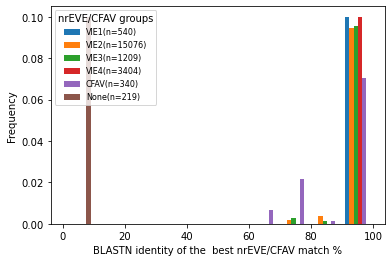

In [42]:
# All mosquito nrEVE assemblies were blasted against previously identified EVEs, CFAV and sequences (VIEW) identified by Whitfield (2017)
# Here, we identify the best match for each contig in each sample
# blast was done with ws7, blastn

eveColours={"VIE1":"blue", "VIE2":"grey", "VIE3":"LimeGreen", "VIE4": "BlueViolet", "CFAV": "red","None":"green"}
legendElements=[]
for key in eveColours:
    legendElements.append(mpatches.Patch(color=eveColours[key], label=key))

eveAssemblies={} #key=assembly name, value=[VIE#, len, identity]
labels=[]
for file in eveColours.keys():
    fileIdentityValues=[]
    if file=="None":
        continue
    with open(wd+"/assembliesVSvie/"+file+".tsv") as blastresults:
        for line in blastresults:
            values=line.strip().split("\t")
            if values[3] not in eveAssemblies:
                eveAssemblies[values[3]]=["None",0,0]
            fileIdentityValues.append(float(values[6]))
            if float(values[2])-float(values[1])>=50 and float(values[6])>=eveAssemblies[values[3]][2]:
                eveAssemblies[values[3]]=[file, float(values[2])-float(values[1]),  float(values[6])]
    labels.append(file)

plot_data=[]
label_data=[]
for key in eveColours:
    plot_data.append( [ value[2] for value in eveAssemblies.values() if value[0]==key ] )
    label_data.append( key+"(n="+str(len(plot_data[-1]))+")" )


plt.hist(plot_data, bins=10, density=True, label=label_data)
plt.xlabel("BLASTN identity of the  best nrEVE/CFAV match %")
plt.ylabel("Frequency")
plt.legend(prop={'size': 8}, loc="upper left", title="nrEVE/CFAV groups")
plt.show()
#the clear separation of high and low similarity sequences is clear. This leads to 90% identity as cut-off for particular contig being homologue of EVE or CFAV sequence

In [9]:
import pickle
# data={}
# for file, label in zip(["allAssembliesVsVir.tsv","allAssembliesVsEVE.tsv","allTrimmedExGenericBlast.tsv"], ["vsVir","vsEVE","vsAll"]):
# #for file, label in zip(["allAssembliesVsVir.tsv","allAssembliesVsEVE.tsv","allTrimmedBlast.tsv"], ["vsVir","vsEVE","vsAll"]):
#     data[label]={}
#     data[label]["rawData"]=pd.read_csv(wd+file, sep="\t", names=["Query","Qstart","Qend","Subject","Start","Sstart","identity","e-value"],
#         dtype={"Vir": str,"VirStart": int,"VirEnd": int,"Assembly": str,"Astart": int,"Aend": int,"identity": float,"e-value": float})
#     data[label]["rawData"]["HitLength"]=abs(data[label]["rawData"]["Qend"]-data[label]["rawData"]["Qstart"])
#     for pivotLabel, pivotValues, fillvalue in zip(["evaluePivot","hitlengthPivot","identityPivot"],["e-value","HitLength","identity"],[1,0,0]):
#         if pivotValues=="HitLength": #hits against same sequence are summed
#             data[label][pivotLabel]=pd.pivot_table(data[label]["rawData"], index=["Query"], columns=["Subject"], values=[pivotValues], aggfunc=np.sum, fill_value=fillvalue)
#         else: #for e-value and identity lowest are used.
#             data[label][pivotLabel]=pd.pivot_table(data[label]["rawData"], index=["Query"], columns=["Subject"], values=[pivotValues], aggfunc=np.min, fill_value=fillvalue)
#         data[label][pivotLabel].columns=[f[1] for f in data[label][pivotLabel].columns]

# with open(wd+"allBlastResultsExGeneric.pkl", 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(wd+"allBlastResultsVirContigsOnly.pkl", 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open(wd+"allBlastResultsVirContigsOnly.pkl", 'rb') as handle: #the assembly contigs are only parts that have match against either EVEs or viruses
#     data = pickle.load(handle)

with open(wd+"allBlastResultsExGeneric.pkl", 'rb') as handle: #the assembly contigs are only parts that have match against either EVEs or viruses and excluding matches against D. rerio
    data = pickle.load(handle)

# with open(wd+"allBlastResults.pkl", 'rb') as handle: whole assembly contigs are used to to all vs all
#     data = pickle.load(handle)


In [29]:
columnToEveGroup={}
for index in data["vsEVE"]["evaluePivot"].index:
        if index.find("AE")>-1:
                columnToEveGroup[index]="VIE"+index.split(".")[1]
        elif index=="NC_001564.2":
                columnToEveGroup[index]="CFAV"
        elif index=="NC_035108.1:461326757-461327206":
                columnToEveGroup[index]="VIE2"
        
#seems all elements have a 0 e-value match to some EVE element
bestEVEmatch={}
for column in data["vsEVE"]["evaluePivot"].columns:
        bestHits=data["vsEVE"]["evaluePivot"].loc[data["vsEVE"]["evaluePivot"][column]==data["vsEVE"]["evaluePivot"][column].min()][column]
        if len(bestHits)>1:
                #0.9 is to account for some hits which are very similar in length, but very different in identity
                longest=data["vsEVE"]["hitlengthPivot"].loc[bestHits.index].loc[data["vsEVE"]["hitlengthPivot"].loc[bestHits.index][column]>data["vsEVE"]["hitlengthPivot"].loc[bestHits.index][column].max()*0.9][column]
                if len(longest)>1:
                        mostIdentical=data["vsEVE"]["identityPivot"].loc[longest.index].loc[data["vsEVE"]["identityPivot"].loc[longest.index][column]==data["vsEVE"]["identityPivot"].loc[longest.index][column].max()][column]
                        randomRow=random.sample(list(mostIdentical.index), k=1)[0] #this is nececssary to randomise hits when two EVE a excellent mathces
                        bestEVEmatch[column]=[randomRow, data["vsEVE"]["evaluePivot"].at[randomRow,column], 
                                        data["vsEVE"]["hitlengthPivot"].at[randomRow,column],data["vsEVE"]["identityPivot"].at[randomRow,column]]
                else:
                        bestEVEmatch[column]=[longest.index[0], data["vsEVE"]["evaluePivot"].at[longest.index[0],column], 
                                        data["vsEVE"]["hitlengthPivot"].at[longest.index[0],column],data["vsEVE"]["identityPivot"].at[longest.index[0],column]]
        else:
                bestEVEmatch[column]=[bestHits.index[0], data["vsEVE"]["evaluePivot"].at[bestHits.index[0],column], 
                                        data["vsEVE"]["hitlengthPivot"].at[bestHits.index[0],column],data["vsEVE"]["identityPivot"].at[bestHits.index[0],column]]

In [11]:
bestVirmatch={} #key=assembly contig, value=[Virus ID, blast evalue, blast length, blast identity]
for row in data["vsVir"]["evaluePivot"].index:
        bestHits=data["vsVir"]["evaluePivot"].columns[data["vsVir"]["evaluePivot"].loc[row]==data["vsVir"]["evaluePivot"].loc[row].min()]
        if len(bestHits)>1:
                longest=data["vsVir"]["hitlengthPivot"].columns[data["vsVir"]["hitlengthPivot"].loc[row]>data["vsVir"]["hitlengthPivot"].loc[row][list(bestHits)].max()*0.9]
                if len(longest)>1:
                        mostIdentical=data["vsVir"]["identityPivot"].columns[data["vsVir"]["identityPivot"].loc[row]==data["vsVir"]["identityPivot"].loc[row][list(longest)].max()]
                        randomColumn=random.sample(list(mostIdentical), k=1)[0] #this is nececssary to randomise hits when two EVE a excellent mathces
                        bestVirmatch[row]=[randomColumn,data["vsVir"]["evaluePivot"].at[row,randomColumn], data["vsVir"]["hitlengthPivot"].at[row,randomColumn],data["vsVir"]["identityPivot"].at[row,randomColumn]]
                else:
                        bestVirmatch[row]=[longest[0],data["vsVir"]["evaluePivot"].at[row,longest[0]], data["vsVir"]["hitlengthPivot"].at[row,longest[0]],data["vsVir"]["identityPivot"].at[row,longest[0]]]
        else:
                bestVirmatch[row]=[bestHits[0],data["vsVir"]["evaluePivot"].at[row,bestHits[0]], data["vsVir"]["hitlengthPivot"].at[row,bestHits[0]],data["vsVir"]["identityPivot"].at[row,bestHits[0]]]

In [12]:
#Get contig overall length
contigLengths={}
lengthIndex=0
for value in data["vsAll"]["evaluePivot"].index[0].split("_"):
    lengthIndex+=1
    if value=="length":
        break
for index in data["vsAll"]["evaluePivot"].index:
    contigLengths[index]=int(index.split("_")[lengthIndex])
    

In [36]:
# filterByLength=np.union1d(data["vsVir"]["rawData"][data["vsVir"]["rawData"]["HitLength"]>50]["Query"], data["vsEVE"]["rawData"][data["vsEVE"]["rawData"]["HitLength"]>50]["Subject"])
# filterByLength=np.union1d(data["vsAll"]["rawData"][data["vsAll"]["rawData"]["identity"]>90]["Query"], filterByLength)
# filterByLength=np.union1d(data["vsAll"]["rawData"][data["vsAll"]["rawData"]["HitLength"]>50]["Query"], filterByLength)
# allVsvir=data["vsAll"]["evaluePivot"].loc[np.intersect1d(data["vsAll"]["evaluePivot"].index, filterByLength )]

# allVsvir=data["vsAll"]["rawData"][data["vsAll"]["rawData"]["Query"].isin(data["vsVir"]["rawData"]["Subject"])]
# filterByLength=np.intersect1d(data["vsAll"]["evaluePivot"].index,data["vsAll"]["rawData"][data["vsAll"]["rawData"]["HitLength"]>50]["Query"])
# allVsvir=data["vsAll"]["evaluePivot"].loc[filterByLength]
allVsvir=data["vsAll"]["evaluePivot"]
# evaluePivot=pd.pivot_table(filteredData, index=filteredData.index, columns=["Query"], values=["e-value"], aggfunc=np.min, fill_value=1)
# evaluePivot.columns=[f[1] for f in evaluePivot.columns]



# #some columns are note present in row labels and vice-versa
allVsvir=allVsvir.loc[np.intersect1d(allVsvir.index, allVsvir.columns)]
allVsvir=allVsvir[allVsvir.index]

In [64]:
tempData.index[ [  f not in bestEVEmatch  for f in  allVsvir.index[largestClusterMask] ] ]

Index(['SRR11006482_NODE_34_length_167_cov_5.444444',
       'SRR11006496_NODE_49_length_84_cov_14.142857',
       'SRR11006496_NODE_50_length_84_cov_12.285714',
       'SRR11006496_NODE_51_length_84_cov_4.000000',
       'SRR11006497_NODE_68_length_82_cov_13.200000',
       'SRR11006499_NODE_33_length_155_cov_4.500000',
       'SRR11006499_NODE_34_length_139_cov_2.693548',
       'SRR11006500_NODE_41_length_254_cov_6.316384',
       'SRR11006508_NODE_53_length_155_cov_8.961538',
       'SRR11006508_NODE_55_length_155_cov_7.346154',
       'SRR11006508_NODE_68_length_132_cov_2.654545',
       'SRR11006525_NODE_105_length_104_cov_11.185185',
       'SRR11006525_NODE_133_length_82_cov_12.400000',
       'SRR11006526_NODE_107_length_90_cov_72.846154',
       'SRR11006526_NODE_94_length_101_cov_13.333333',
       'SRR11006526_NODE_95_length_101_cov_11.041667',
       'SRR11006534_NODE_45_length_101_cov_9.333333',
       'SRR11006534_NODE_46_length_101_cov_5.083333',
       'SRR11006536_NOD

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


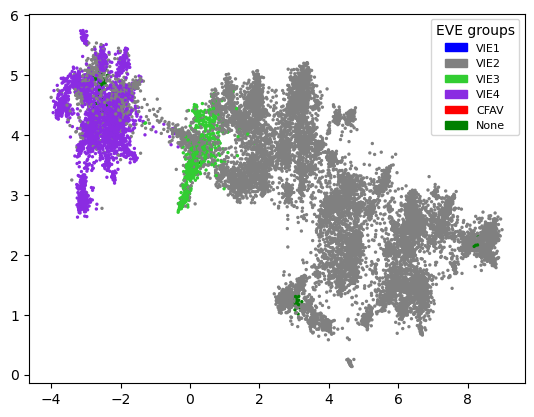

In [59]:
largestClusterMask=np.where(clusters==21)[0]
tempData=allVsvir.iloc[largestClusterMask][allVsvir.columns[largestClusterMask]]
temp=umap.UMAP(n_neighbors=50, min_dist=0.1, metric="precomputed").fit_transform(tempData)
plt.scatter(temp[:,0],temp[:,1], s=2, 
        c=[ eveColours[columnToEveGroup[bestEVEmatch[f][0]]] if f in bestEVEmatch else eveColours["None"]  for f in  allVsvir.index[largestClusterMask] ])
plt.legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
plt.show()
#tempData.to_csv(wd+"cluster20Matrix.tsv", sep="\t")

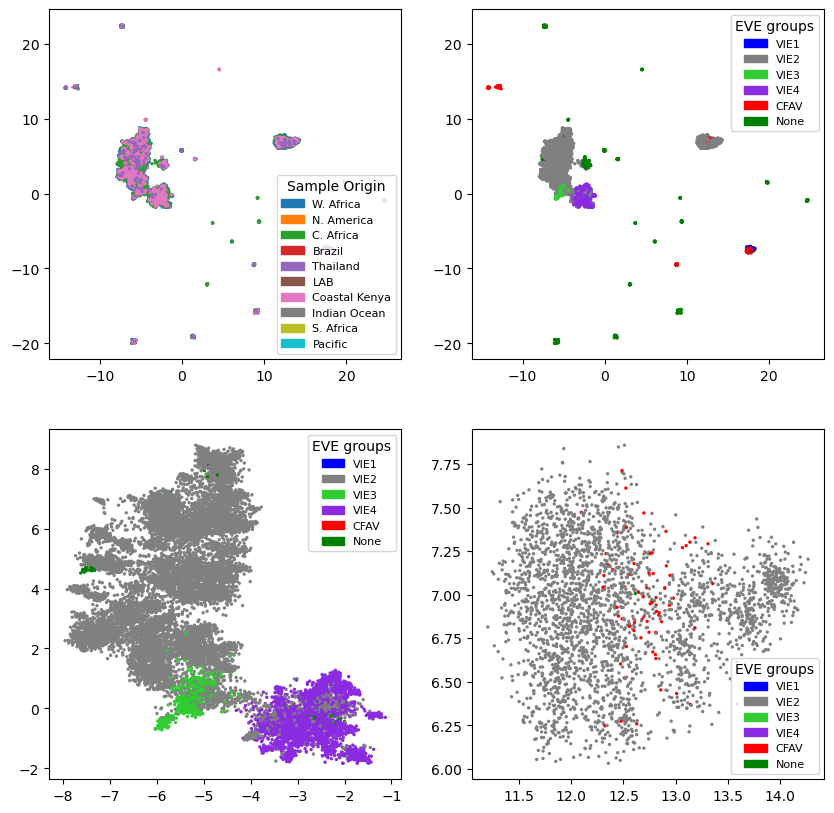

In [33]:
#embeddedVCF=umap.UMAP(n_neighbors=50, min_dist=0.1, unique=True, metric="precomputed").fit_transform(evaluePivot)

#embeddedVCF=umap.UMAP(n_neighbors=50, min_dist=0.3, metric="precomputed").fit_transform(allVsvir)
# with open(wd+"allVsvirUmap.pkl", 'wb') as handle:
#     pickle.dump(embeddedVCF, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(wd+"allVsvirUmap.pkl", 'rb') as handle:
    embeddedVCF = pickle.load(handle)    

clusters = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=0.5).fit(embeddedVCF).labels_

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,10)
axs[0,0].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ regionColoursDic[sampleRegionsDic[f.split("_")[0]]] for f in  allVsvir.index ])
axs[0,0].legend(handles=geographyLegendElements,prop={'size': 8}, loc="best", title="Sample Origin")
axs[0,1].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ eveColours[columnToEveGroup[bestEVEmatch[f][0]]] if f in bestEVEmatch else eveColours["None"]  for f in  allVsvir.index ])
axs[0,1].legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
# plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=clusters, cmap="tab20")
# plt.show()

counter=0
for key in sorted(Counter(clusters), key=Counter(clusters).get, reverse=True):
    if counter>1:
        break
    #create subplot for the largest cluster 
    #largestCluster=max(Counter(clusters), key=Counter(clusters).get)
    largestClusterMask=np.where(clusters==key)[0]
    axs[1,counter].scatter(embeddedVCF[largestClusterMask,0],embeddedVCF[largestClusterMask,1], s=2, 
        c=[ eveColours[columnToEveGroup[bestEVEmatch[f][0]]] if f in bestEVEmatch else eveColours["None"]  for f in  allVsvir.index[largestClusterMask] ])
    axs[1,counter].legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
    counter+=1
plt.show()

with open(wd+"umapAllvsAll.tsv", "w") as output:
    output.write('\t'.join(["Sample","Contig","ContigLen","X1","X2", 
     "Virus", "Vir Blast evalue", "Vir Blast length", "Vir Blast identity",
     "VIE","EVE", "EVE Blast evalue", "EVE Blast length", "EVE Blast identity",
      "Region","Country", "Cluster"])+"\n")
    for i, index in zip(range(0,len(allVsvir.index )), allVsvir.index ):
        bestVirProfile='\t'.join([str(f) for f in bestVirmatch[index]]) if index in bestVirmatch else "\t\t\t"
        bestEVEProfile='\t'.join([str(f) for f in bestEVEmatch[index]]) if index in bestEVEmatch else "\t\t\t"

        if index in bestEVEmatch:
            output.write( "\t".join( [str(f) for f in [index.split("_")[0], index, contigLengths[index], embeddedVCF[i,0],embeddedVCF[i,1], 
                bestVirProfile, columnToEveGroup[bestEVEmatch[index][0]],  bestEVEProfile,
                sampleRegionsDic[index.split("_")[0]], sampleCountryDic[index.split("_")[0]],  clusters[i] ]     ]  ) +"\n")
        else:
            output.write( "\t".join( [str(f) for f in [index.split("_")[0], index, contigLengths[index], embeddedVCF[i,0],embeddedVCF[i,1], 
                bestVirProfile, "None", bestEVEProfile,
                sampleRegionsDic[index.split("_")[0]], sampleCountryDic[index.split("_")[0]],  clusters[i] ]      ]  ) +"\n")


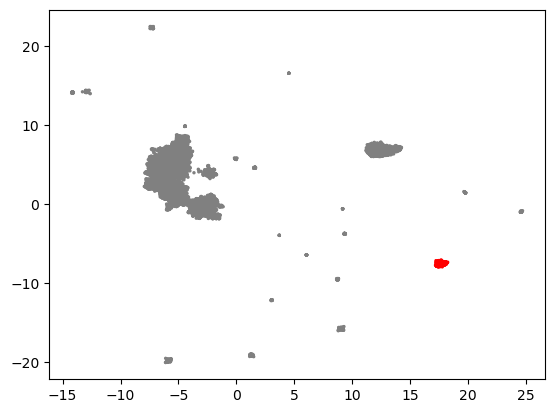

In [45]:
plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ "grey" if f!=8 else "red" for f in  clusters])
plt.show()

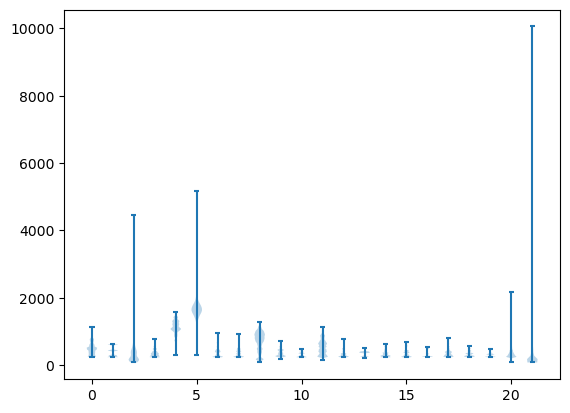

In [108]:
violinData=[]
violinPositions=[]
for key in Counter(clusters):
    violinData.append( [contigLengths[f] for f in allVsvir.index[np.where(clusters==key)[0]] ]   )
    violinPositions.append(key)
plt.violinplot(violinData, violinPositions ,points=100, bw_method=0.1 )
#plt.ylim( (0, 1000) )
plt.show()

Not usable: 0 out of 263


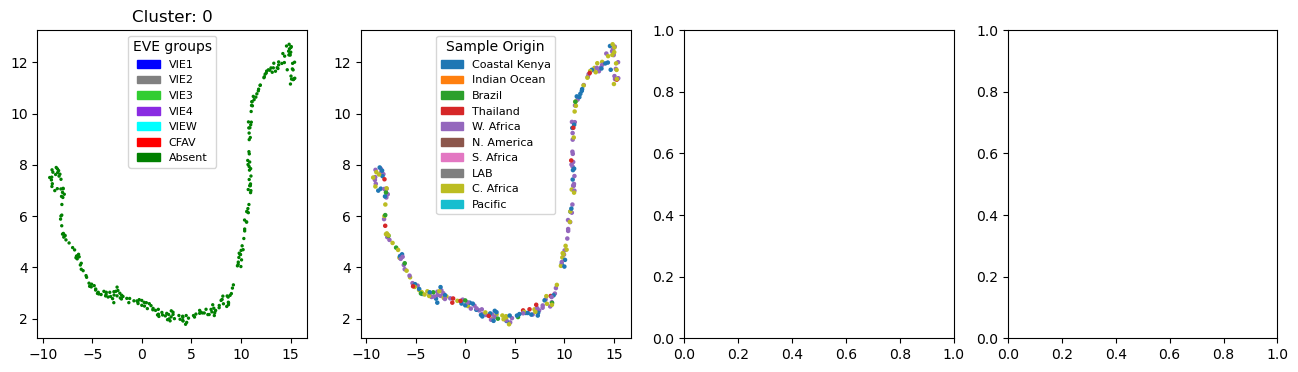

Not usable: 36 out of 563
Not usable: 515 out of 563


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


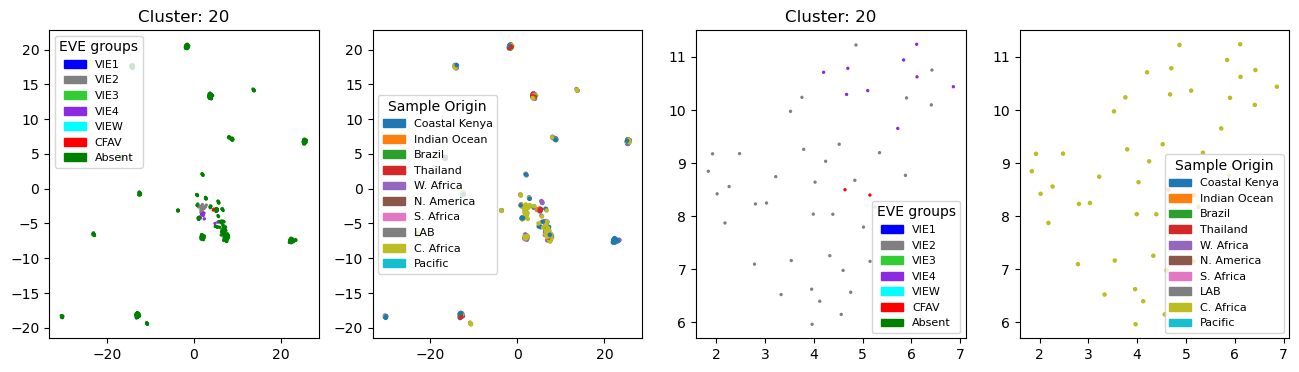

Not usable: 18 out of 600
Not usable: 50 out of 600


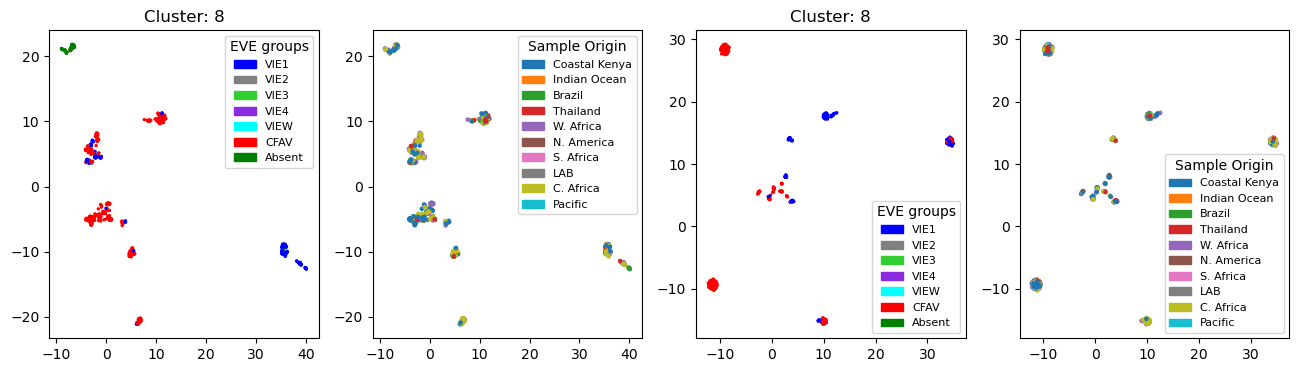

Not usable: 0 out of 266


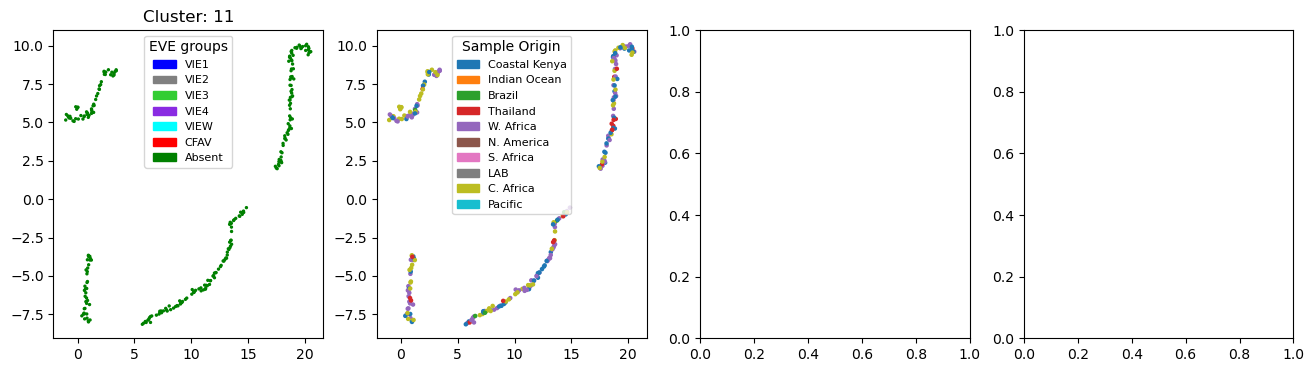

Not usable: 0 out of 166


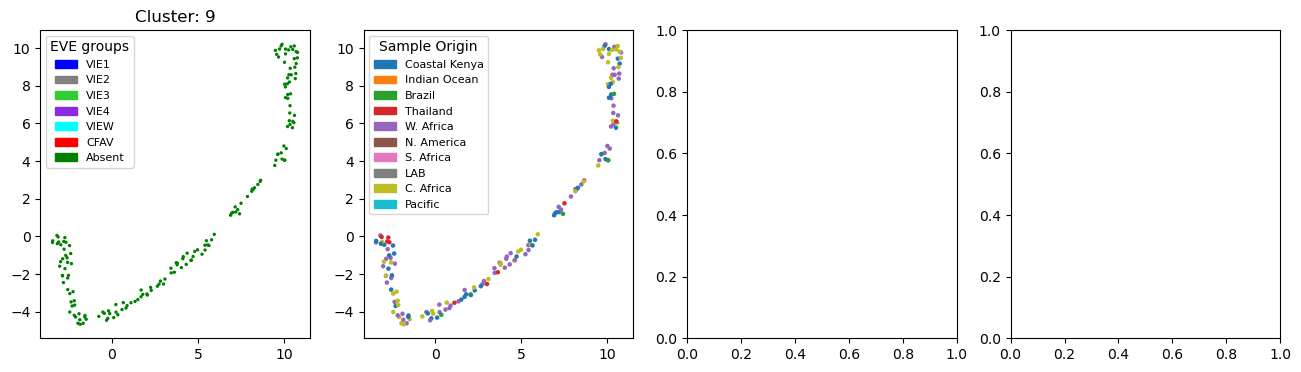

Not usable: 3 out of 165


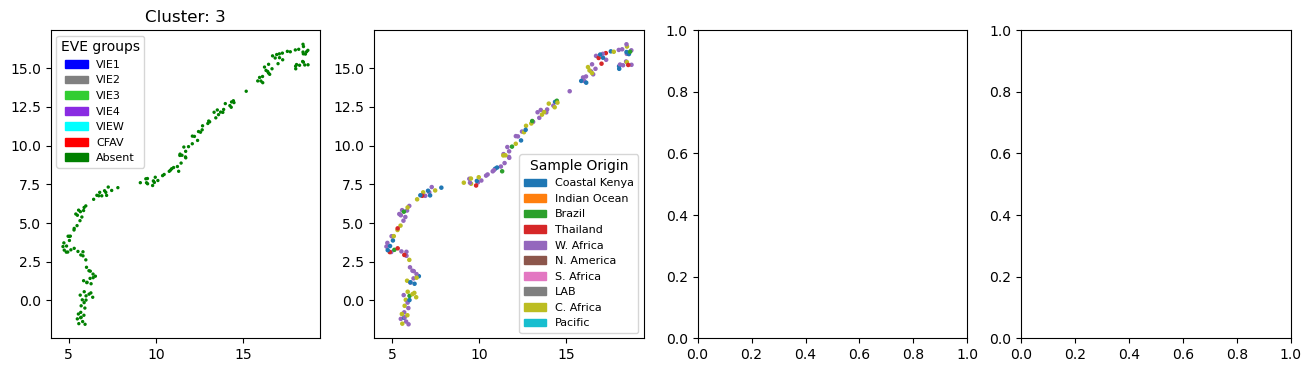

Not usable: 0 out of 44


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


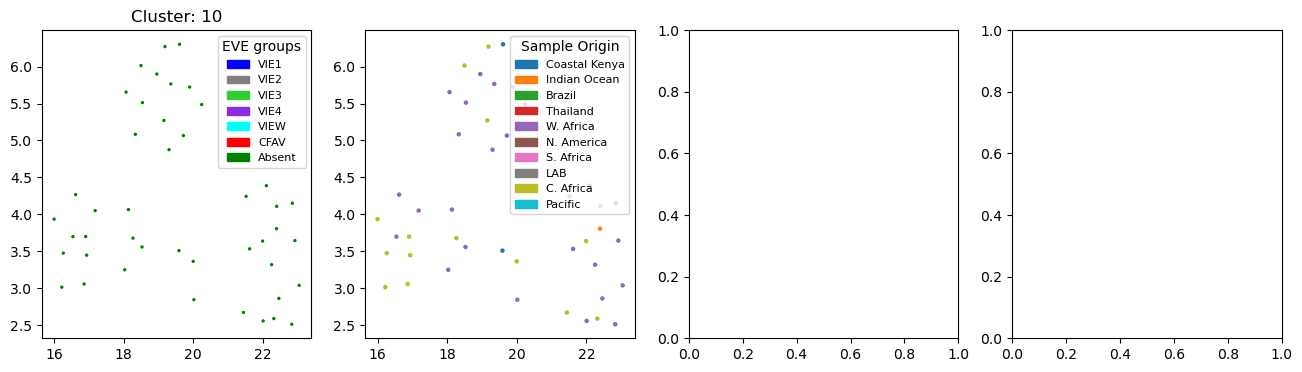

Not usable: 0 out of 90
Not usable: 6 out of 90


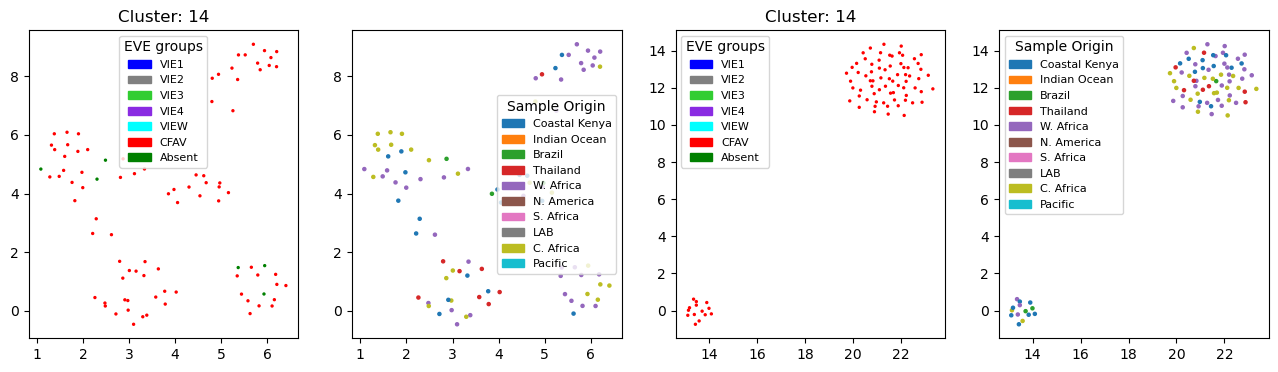

Not usable: 0 out of 89


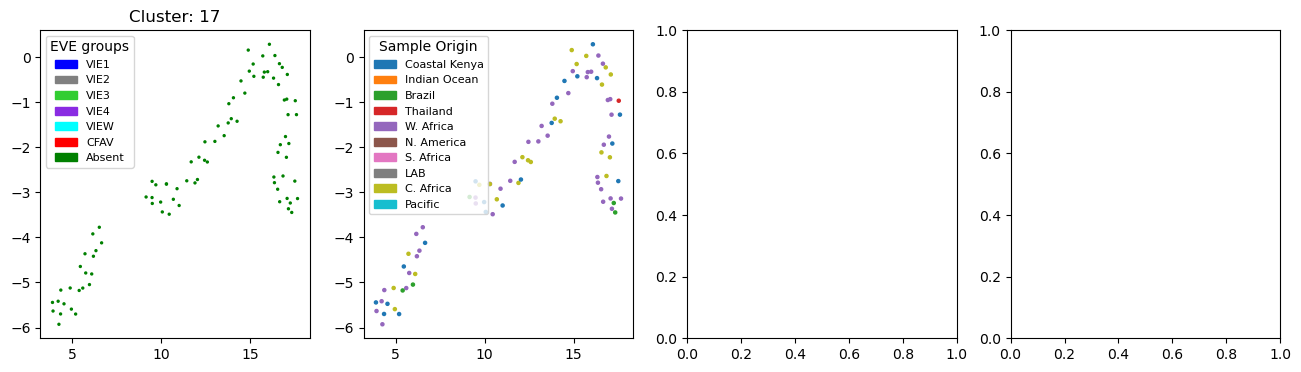

Not usable: 6 out of 65


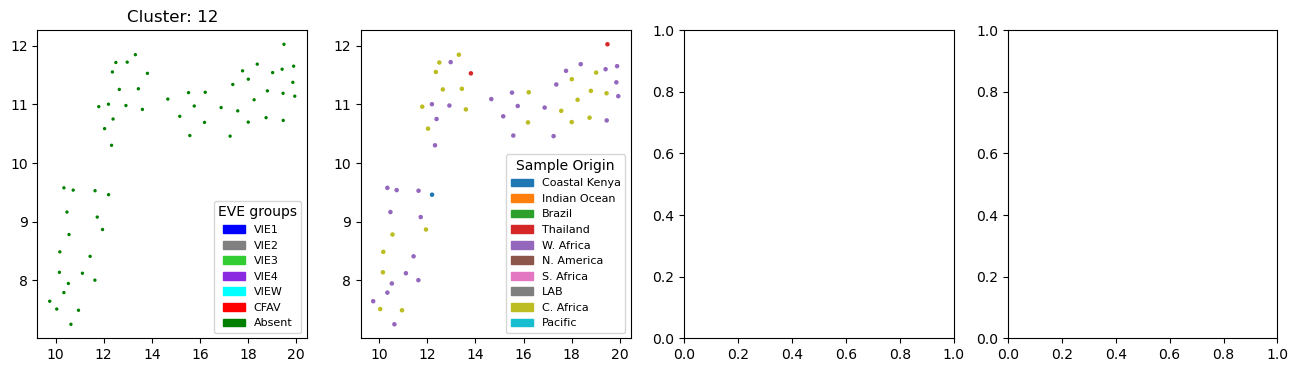

Not usable: 0 out of 53


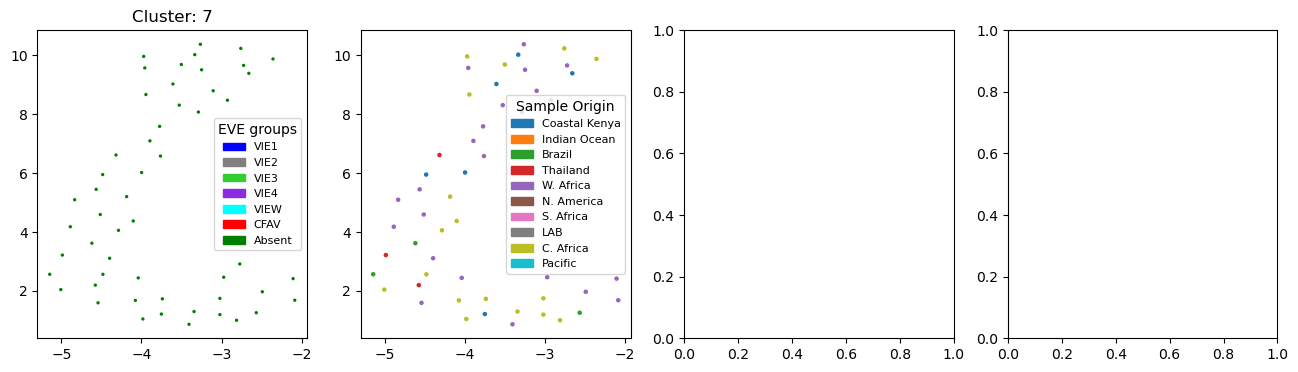

Not usable: 0 out of 167
Not usable: 0 out of 167


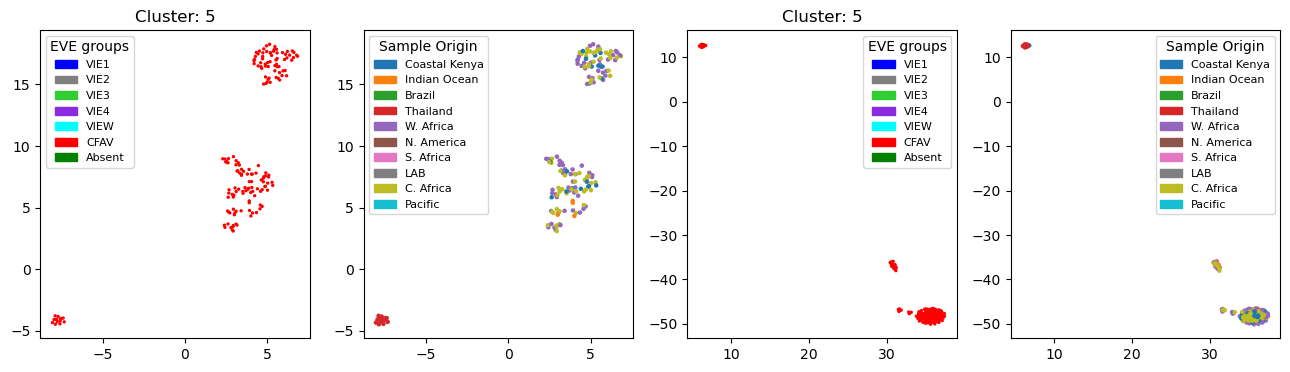

Not usable: 0 out of 52


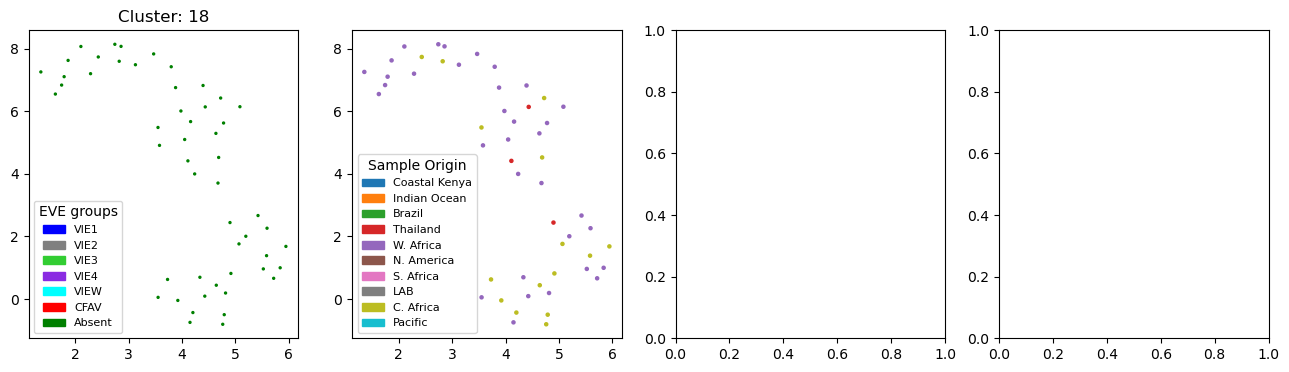

Not usable: 0 out of 77
Not usable: 0 out of 77


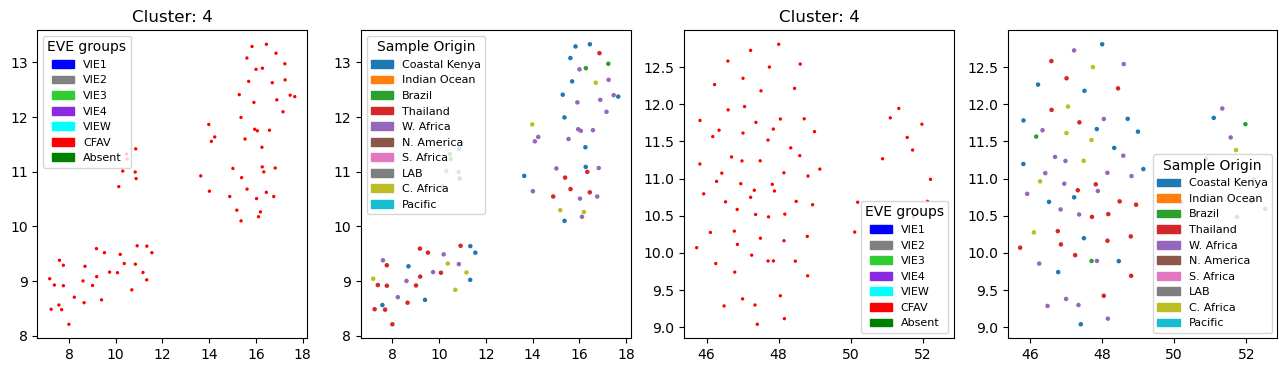

Not usable: 3 out of 7


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


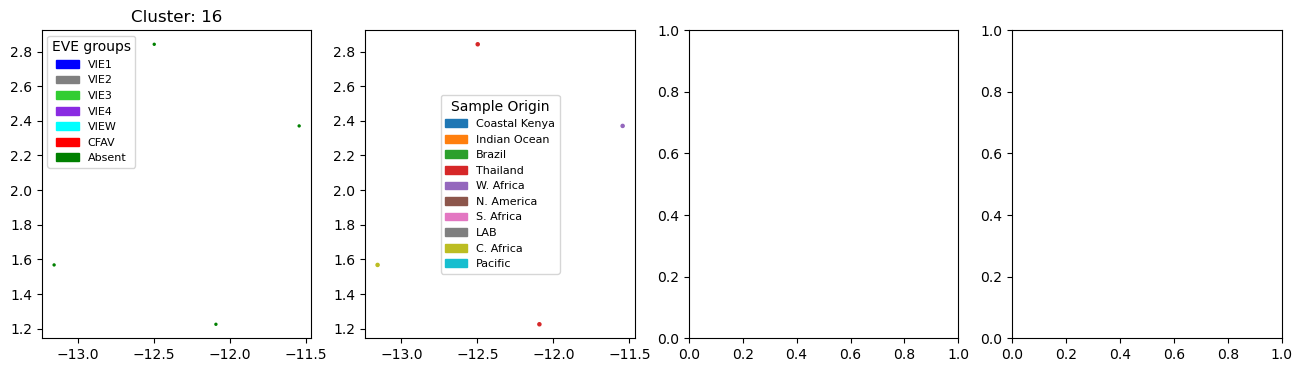

Not usable: 0 out of 56


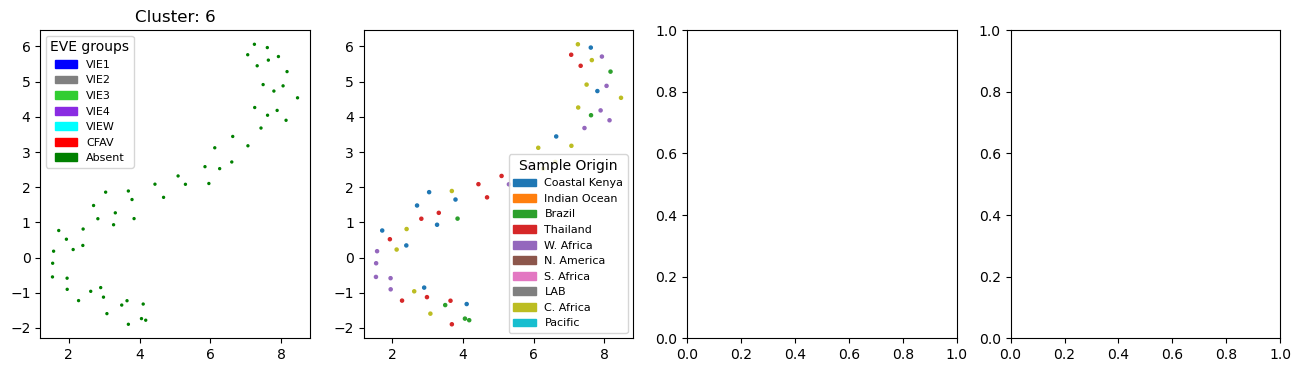

Not usable: 0 out of 19


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


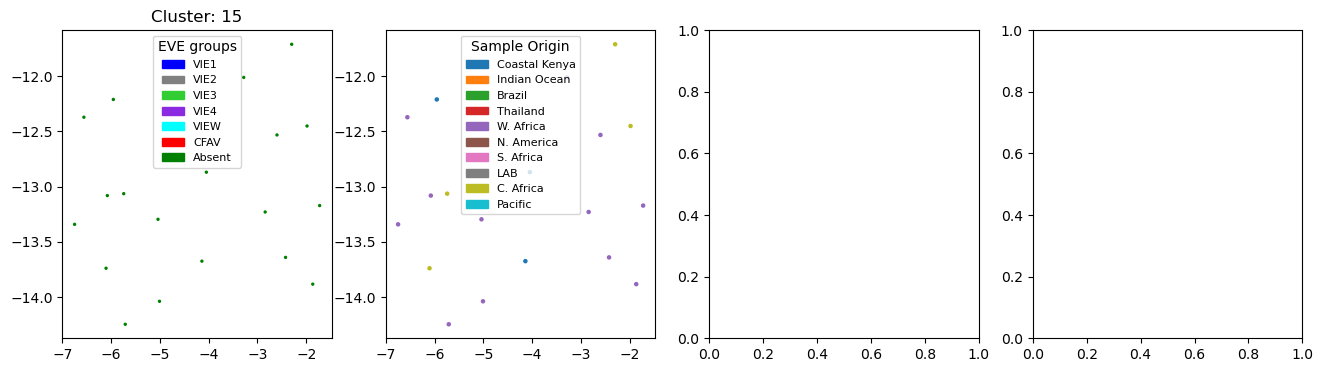

Not usable: 0 out of 11


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


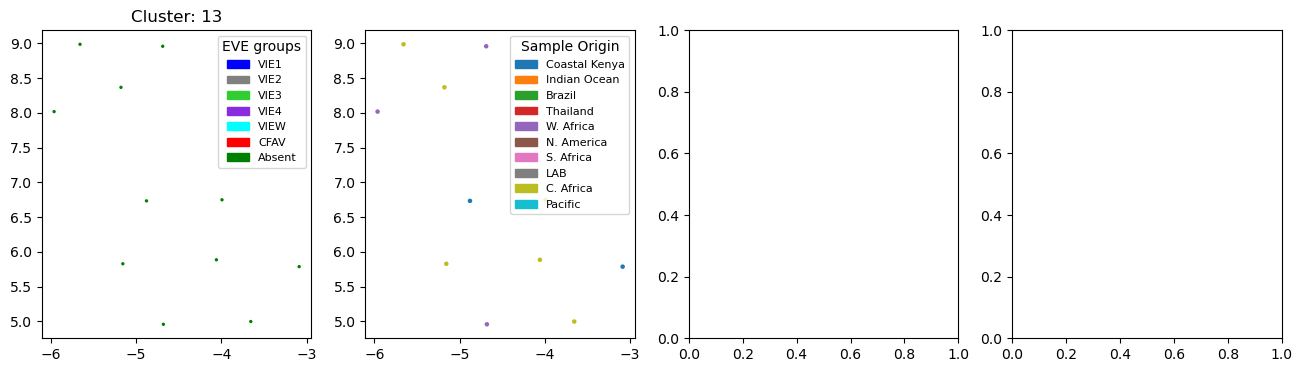

Not usable: 0 out of 17


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


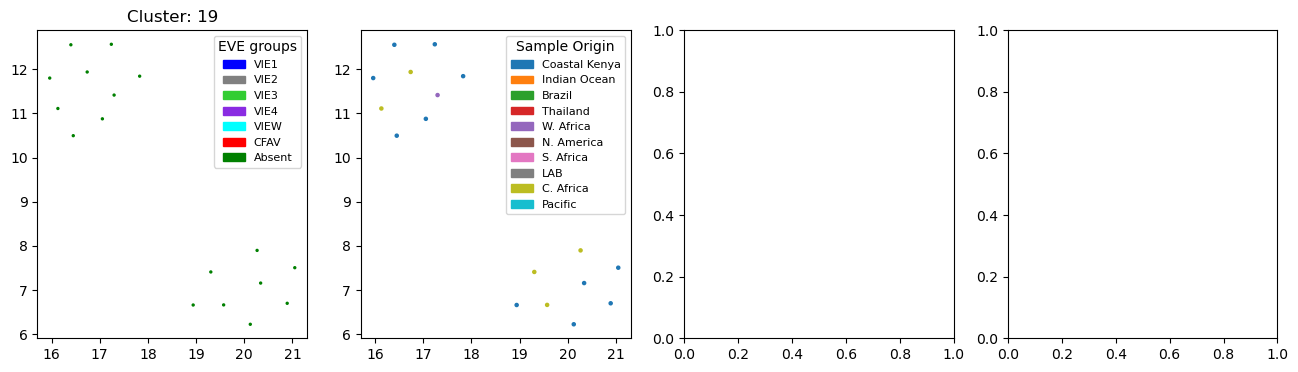

Not usable: 0 out of 8


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


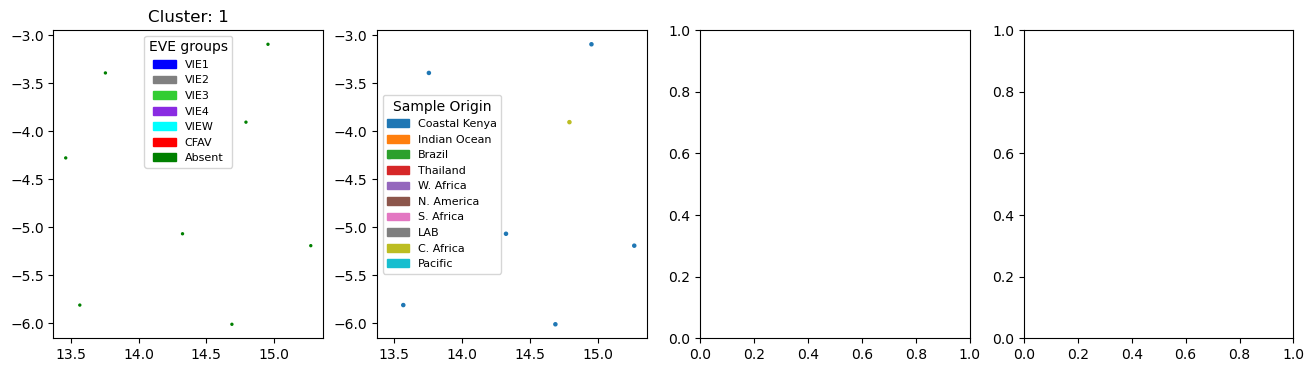

In [17]:
for key in Counter(clusters):
    if key in [21,2]:
        continue
    clusterMask=np.where(clusters==key)[0]
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(h=4,w=16)
    for dataFileLabel, positions in zip( ["vsVir","vsEVE"], [ (0,1), (2,3)]  ):
        if dataFileLabel=="vsVir":
            validclusterMask=np.intersect1d(allVsvir.index[clusterMask],data[dataFileLabel]["evaluePivot"].index)
        else:
            validclusterMask=np.intersect1d(allVsvir.index[clusterMask],data[dataFileLabel]["evaluePivot"].columns)
        if len(validclusterMask)==0:
            continue
        print("Not usable: " + str(len(clusterMask)-len(validclusterMask)) + " out of " + str(len(clusterMask)) )
        
        if dataFileLabel=="vsVir":
            newData=data[dataFileLabel]["evaluePivot"].loc[validclusterMask]
            newData=newData.join(data[dataFileLabel]["hitlengthPivot"].loc[validclusterMask], rsuffix='_length')            
        else:
            newData=np.transpose(data[dataFileLabel]["evaluePivot"]).loc[validclusterMask]
            newData=newData.join( np.transpose(data[dataFileLabel]["hitlengthPivot"]).loc[validclusterMask] , rsuffix='_length')
        
        clusterembedding=umap.UMAP(n_neighbors=50, min_dist=0.3, metric="euclidean").fit_transform(StandardScaler().fit_transform(newData))

        axs[positions[0]].scatter(clusterembedding[:,0],clusterembedding[:,1], s=2, 
            c=[ eveColours[columnToEveGroup[bestEVEmatch[f][0]]] if f in bestEVEmatch else eveColours["None"]  for f in  validclusterMask ])
        axs[positions[0]].legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
        axs[positions[0]].set_title("Cluster: "+str(key))
        axs[positions[1]].scatter(clusterembedding[:,0],clusterembedding[:,1], s=5, c=[ regionColoursDic[sampleRegionsDic[f.split("_")[0]]] for f in  validclusterMask ])
        axs[positions[1]].legend(handles=geographyLegendElements,prop={'size': 8}, loc="best", title="Sample Origin")    
    plt.show()


In [13]:
#Count how many samples per country belong to a cluster
allSamples=np.unique([f.split("_")[0] for f in allVsvir.index])
countryCounts=Counter([ sampleCountryDic[f] for f in allSamples    ])
clusterCounts={}
for i in range(0,len(allVsvir.index)):
    if clusters[i] not in clusterCounts:
        clusterCounts[ clusters[i] ]=set()
    clusterCounts[ clusters[i] ].add(allVsvir.index[i].split("_")[0])
samplesPerCluster=pd.DataFrame(0.0,index=clusterCounts.keys(), columns=countryCounts.keys(), )
for cluster in clusterCounts:
    countriesInCluster=Counter([sampleCountryDic[f] for f in  clusterCounts[cluster] ])
    for country in countriesInCluster:
        samplesPerCluster.at[cluster,country] = countriesInCluster[country]/countryCounts[country]
samplesPerCluster["Total"]=[len(clusterCounts[f]) for f in samplesPerCluster.index ]
samplesPerCluster.loc["Total"]=[countryCounts[f] for f in samplesPerCluster.columns]
samplesPerCluster

,Senegal,Kenya,Thailand,Burkina Faso,Ghana,Nigeria,Mauritius,Gabon,Brazil,Uganda,Total
21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.0000,1.000000,464
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.0000,1.000000,464
0,0.572727,0.545455,0.789474,0.542857,0.523810,0.684211,0.00,0.487179,0.7500,0.513514,260
20,0.645455,0.608392,0.736842,0.571429,0.571429,0.526316,1.00,0.666667,0.5000,0.702703,290
8,0.945455,0.944056,1.000000,0.942857,0.904762,0.842105,0.00,0.923077,0.9375,0.972973,432
11,0.554545,0.531469,1.000000,0.628571,0.571429,0.526316,0.00,0.769231,0.3125,0.405405,262
9,0.327273,0.356643,0.473684,0.371429,0.357143,0.368421,0.00,0.410256,0.2500,0.378378,165
3,0.490909,0.279720,0.526316,0.228571,0.333333,0.315789,0.00,0.333333,0.5000,0.324324,165
10,0.127273,0.069930,0.000000,0.085714,0.190476,0.052632,0.25,0.025641,0.0000,0.162162,44
14,0.190909,0.174825,0.421053,0.314286,0.095238,0.052632,0.00,0.256410,0.1875,0.189189,90


In [76]:
clusterMask=np.intersect1d( allVsvir.index[np.where(clusters==8)[0]] , data["vsVir"]["hitlengthPivot"].index)

print(np.percentile( [ max(data["vsVir"]["hitlengthPivot"].loc[f]) for f in clusterMask ], 10, interpolation='nearest'))
print(np.percentile( [ max(data["vsVir"]["hitlengthPivot"].loc[f]) for f in clusterMask ], 90, interpolation='nearest'))

77
317


Not usable: 18 out of 600
Not usable: 50 out of 600


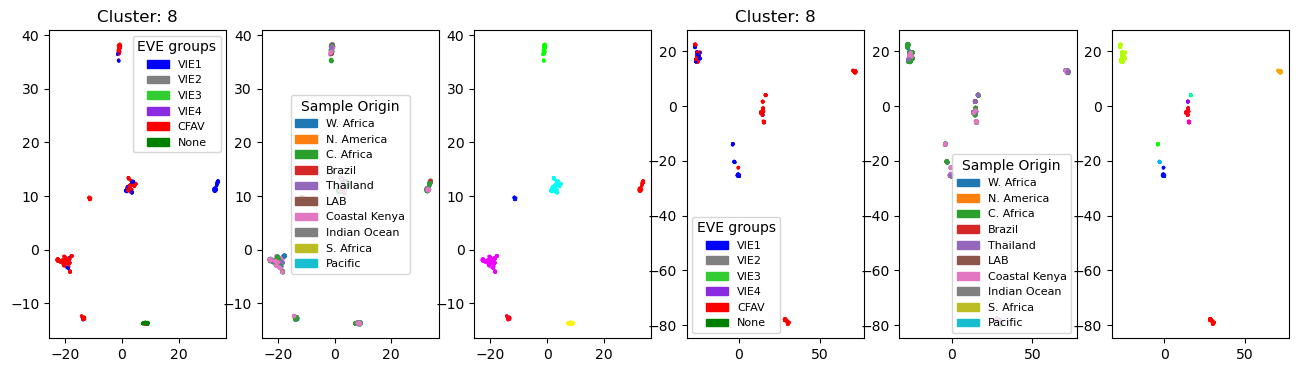

,Senegal,Thailand,Kenya,Burkina Faso,Ghana,Nigeria,Gabon,Brazil,Uganda
3,0.365385,0.368421,0.278195,0.303030,0.368421,0.437500,0.600000,0.200000,0.277778
0,0.115385,0.210526,0.187970,0.090909,0.105263,0.125000,0.142857,0.266667,0.138889
2,0.125000,0.315789,0.210526,0.242424,0.131579,0.125000,0.142857,0.266667,0.250000
6,0.115385,0.000000,0.045113,0.030303,0.105263,0.062500,0.085714,0.000000,0.222222
5,0.336538,0.157895,0.443609,0.393939,0.421053,0.562500,0.257143,0.000000,0.250000
4,0.086538,0.315789,0.037594,0.000000,0.000000,0.000000,0.000000,0.400000,0.083333
1,0.048077,0.000000,0.127820,0.151515,0.157895,0.125000,0.171429,0.000000,0.055556


In [57]:
#["evaluePivot","hitlengthPivot","identityPivot"]
pivotTableLabel="hitlengthPivot"
secondPivotTableLabel="identityPivot"
targetCluster=8
clusterMask=np.where(clusters==targetCluster)[0]
subclusters={}
subclustersPivots={}
fig, axs = plt.subplots(1, 6)
fig.set_size_inches(h=4,w=16)
for dataFileLabel, positions in zip( ["vsVir","vsEVE"], [ (0,1,2), (3,4,5)]  ):
    if dataFileLabel=="vsVir":
        validclusterMask=np.intersect1d(allVsvir.index[clusterMask],data[dataFileLabel][pivotTableLabel].index)
    else:
        validclusterMask=np.intersect1d(allVsvir.index[clusterMask],data[dataFileLabel][pivotTableLabel].columns)
    if len(validclusterMask)==0:
        continue
    print("Not usable: " + str(len(clusterMask)-len(validclusterMask)) + " out of " + str(len(clusterMask)) )
    
    if dataFileLabel=="vsVir":
        newData=data[dataFileLabel][pivotTableLabel].loc[validclusterMask]
        newData=newData.join(data[dataFileLabel][secondPivotTableLabel].loc[validclusterMask], rsuffix='_length')            
    else:
        newData=np.transpose(data[dataFileLabel][pivotTableLabel]).loc[validclusterMask]
        newData=newData.join( np.transpose(data[dataFileLabel][secondPivotTableLabel]).loc[validclusterMask] , rsuffix='_length')

    clusterembedding=umap.UMAP(n_neighbors=200, min_dist=0.1, metric="euclidean").fit_transform(StandardScaler().fit_transform(newData))
    subclusters[dataFileLabel]=hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=2).fit(clusterembedding).labels_

    axs[positions[0]].scatter(clusterembedding[:,0],clusterembedding[:,1], s=2, 
       c=[ eveColours[columnToEveGroup[bestEVEmatch[f][0]]] if f in bestEVEmatch else eveColours["None"]  for f in  validclusterMask ])
    axs[positions[0]].legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
    axs[positions[0]].set_title("Cluster: "+str(targetCluster))
    axs[positions[1]].scatter(clusterembedding[:,0],clusterembedding[:,1], s=5, c=[ regionColoursDic[sampleRegionsDic[f.split("_")[0]]] for f in  validclusterMask ])
    axs[positions[1]].legend(handles=geographyLegendElements,prop={'size': 8}, loc="best", title="Sample Origin")    
    axs[positions[2]].scatter(clusterembedding[:,0],clusterembedding[:,1], s=2, c=subclusters[dataFileLabel], cmap="hsv")    
    

    #Count how many samples per country belong to a cluster
    allSamples=np.unique([f.split("_")[0] for f in newData.index])
    countryCounts=Counter([ sampleCountryDic[f] for f in allSamples    ])
    clusterCounts={}
    for i in range(0,len(newData.index)):
        if subclusters[dataFileLabel][i] not in clusterCounts:
            clusterCounts[ subclusters[dataFileLabel][i] ]=set()
        clusterCounts[ subclusters[dataFileLabel][i] ].add(newData.index[i].split("_")[0])
    samplesPerCluster=pd.DataFrame(0.0,index=clusterCounts.keys(), columns=countryCounts.keys(), )
    for cluster in clusterCounts:
        countriesInCluster=Counter([sampleCountryDic[f] for f in  clusterCounts[cluster] ])
        for country in countriesInCluster:
            samplesPerCluster.at[cluster,country] = countriesInCluster[country]/countryCounts[country]
    #samplesPerCluster["Total"]=[len(clusterCounts[f]) for f in samplesPerCluster.index ]
    #samplesPerCluster.loc["Total"]=[countryCounts[f] for f in samplesPerCluster.columns]

    subclustersPivots[dataFileLabel]=samplesPerCluster
plt.show()

subclustersPivots["vsVir"].style.background_gradient(cmap='Blues')
#subclustersPivots["vsEVE"].style.background_gradient(cmap='Blues')


In [122]:
subclustersPivots["vsVir"].style.background_gradient(cmap='Blues')
#subclustersPivots["vsEVE"].style.background_gradient(cmap='Blues')


,Senegal,Kenya,Thailand,Burkina Faso,Ghana,Nigeria,Mauritius,Gabon,Brazil,Uganda
2,0.941176,0.860465,1.000000,0.900000,0.818182,0.888889,1.000000,0.769231,1.000000,0.840000
0,0.044118,0.046512,0.000000,0.050000,0.000000,0.000000,0.750000,0.076923,0.000000,0.080000
3,0.014706,0.046512,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.200000
1,0.044118,0.255814,0.000000,0.100000,0.090909,0.000000,0.000000,0.115385,0.000000,0.000000
6,0.000000,0.069767,0.285714,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.040000
5,0.014706,0.046512,0.000000,0.000000,0.000000,0.111111,0.000000,0.115385,0.000000,0.000000
4,0.029412,0.000000,0.000000,0.050000,0.136364,0.111111,0.000000,0.038462,0.000000,0.040000


Not usable: 36 out of 563
Not usable: 515 out of 563


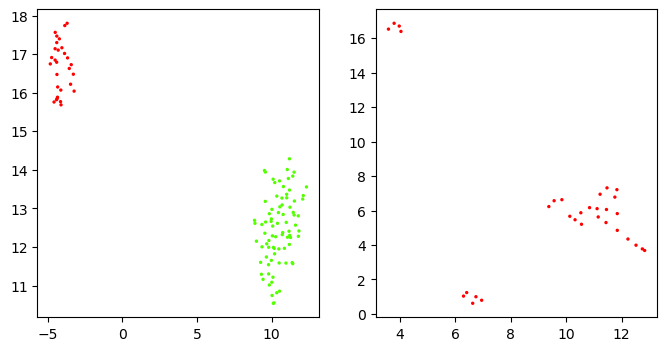

In [125]:
#["evaluePivot","hitlengthPivot","identityPivot"]
pivotTableLabel="hitlengthPivot"
secondPivotTableLabel="hitlengthPivot"
targetCluster=20
clusterMask=np.where(clusters==targetCluster)[0]
subclusters={}
subclustersPivots={}
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(h=4,w=8)
for dataFileLabel, positions in zip( ["vsVir","vsEVE"], [ 0,1 ]  ):
    if dataFileLabel=="vsVir":
        validclusterMask=np.intersect1d(allVsvir.index[clusterMask],data[dataFileLabel][pivotTableLabel].index)
    else:
        validclusterMask=np.intersect1d(allVsvir.index[clusterMask],data[dataFileLabel][pivotTableLabel].columns)
    if len(validclusterMask)==0:
        continue
    print("Not usable: " + str(len(clusterMask)-len(validclusterMask)) + " out of " + str(len(clusterMask)) )
    
    if dataFileLabel=="vsVir":
        newData=data[dataFileLabel][pivotTableLabel].loc[validclusterMask]
        #newData=newData.join(data[dataFileLabel][secondPivotTableLabel].loc[validclusterMask], rsuffix='_length')            
    else:
        newData=np.transpose(data[dataFileLabel][pivotTableLabel]).loc[validclusterMask]
        #newData=newData.join( np.transpose(data[dataFileLabel][secondPivotTableLabel]).loc[validclusterMask] , rsuffix='_length')

    clusterembedding=umap.UMAP(n_neighbors=5, min_dist=0.1, metric="euclidean").fit_transform(StandardScaler().fit_transform(np.transpose(newData)))
    subclusters[dataFileLabel]={"labels": newData.columns, 
            "clusters":hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=1).fit(clusterembedding).labels_,
            "sums":np.sum(newData,axis=0),
            "data":newData  }
    axs[positions].scatter(clusterembedding[:,0],clusterembedding[:,1], s=2, c=subclusters[dataFileLabel]["clusters"], cmap="prism")


plt.show()

with open(wd+"VirusClusters.tsv","w") as output:
    output.write("ID\tCluster\n")
    for i in range(0, len(subclusters["vsVir"]["labels"])):
        output.write(subclusters["vsVir"]["labels"][i]+"\t"+str(subclusters["vsVir"]["clusters"][i])+"\t"+str(subclusters["vsVir"]["sums"][i])+"\n")



In [ ]:
#embeddedVCF=umap.UMAP(n_neighbors=50, min_dist=0.1, unique=True, metric="precomputed").fit_transform(evaluePivot)
embeddedVCF=umap.UMAP(n_neighbors=20, min_dist=0.1, metric="precomputed").fit_transform(allVsvir)
clusters = DBSCAN(eps=1.5, min_samples=5).fit(embeddedVCF).labels_

plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ regionColoursDic[sampleRegionsDic[f.split("_")[0]]] for f in  allVsvir.index ])
plt.legend(handles=geographyLegendElements,prop={'size': 8}, loc="best", title="EVE groups")
plt.show()
plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ eveColours[columnToEveGroup[bestEVEmatch[f][0]]] if f in bestEVEmatch else eveColours["None"]  for f in  allVsvir.index ])
plt.legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
plt.show()
plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=clusters, cmap="tab20")
plt.show()

In [6]:
#this relies on all assembles vs all assemblies blast. The problem is pairing based on repeat elements
#this gives little clarity on the relatinonship to virial genomes

#this was used for tsv to pandas conversion, but loading is a lot slower than pickle. So for most purposes pickle is used.
#AllvsAllassemblies=pd.read_csv(wd+"allVSall.tsv", sep="\t", names=["Query","Qstart","Qend","Subject","Sstart","Send","identity","e-value"],
        #dtype={"Query": np.str,"Qstart": np.int,"Qend": np.int,"Subject": np.str,"Sstart": np.int,"Send": np.int,"identity": np.float,"e-value": np.float})
#AllvsAllassemblies=pd.pivot_table(AllvsAllassemblies, index=["Query"], columns=["Subject"], values=["e-value"], aggfunc=np.min, fill_value=1)
#AllvsAllassemblies.to_pickle(wd+"allVSall.pkl")

AllvsAllassemblies=pd.read_pickle(wd+"allVSall.pkl")
AllvsAllassembliesMatrix=AllvsAllassemblies.to_numpy()

allVSallContigs=set(AllvsAllassemblies.index)

contigNames=list(contigSequences.keys())
missingIndex=np.where(np.isin(contigNames, list(allVSallContigs), invert=True, assume_unique=True))[0]
missingContigs=np.array(contigNames)[missingIndex]
missingSequences={}
for contig in missingContigs:
    missingSequences[contig]=contigSequences[contig]
#the missing contigs (i.e. the ones that didn't produce any hits), appear artifactual and will be ignored. There are only 6

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1737: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


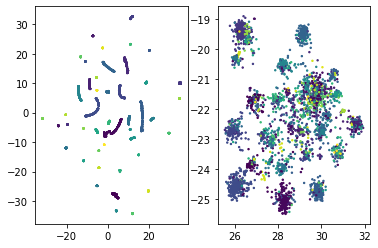

In [7]:
#Analysis of contigs not relate dto EVEs/CFAV
import umap
from sklearn.cluster import DBSCAN
from collections import Counter

#identify assemblies that are not don't pass the EVE/CFAV similarity test
nonEVEassemblies=[]
for value in assembliesVsVir.index:
    if value not in eveAssemblies or eveAssemblies[value][0]==0:
        nonEVEassemblies.append(value)

#cluster the contigs that do not pass similarity threshold for core EVEs or CFAV. Basis for clustering is the similarity to viral genomes
nonEVEindex=np.where(np.isin(assembliesVsVir.index, nonEVEassemblies,assume_unique=True))[0]
X_embedded_nonEVEvsVir = umap.UMAP(n_neighbors=50, min_dist=0.1, metric="euclidean").fit_transform(assembliesVsVirMatrix[nonEVEindex,:])
clusteringnonEVEvsVir = DBSCAN(eps=1.5, min_samples=5).fit(X_embedded_nonEVEvsVir).labels_

#cluster the contigs that do not pass similarity threshold for core EVEs or CFAV. Basis for clustering is the similarity between contigs
nonEVEAllvsAllindex=np.where(np.isin(AllvsAllassemblies.index, nonEVEassemblies,assume_unique=True))[0]
ContigIdsnonEVEAllvsAll=list(AllvsAllassemblies.index[nonEVEAllvsAllindex])
X_embedded_nonEVEallVsAll=umap.UMAP(n_neighbors=50, min_dist=0.1, metric="precomputed").fit_transform(AllvsAllassembliesMatrix[nonEVEAllvsAllindex,:][:,nonEVEAllvsAllindex])
clusteringnonEVEallVsAll = DBSCAN(eps=1.5, min_samples=5).fit(X_embedded_nonEVEallVsAll).labels_

colors=[]
for id in ContigIdsnonEVEAllvsAll:
    if id in nonEVEassemblies:
        colors.append(clusteringnonEVEvsVir[nonEVEassemblies.index(id)])
    else:
        colors.append(-2)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(X_embedded_nonEVEvsVir[:,0],X_embedded_nonEVEvsVir[:,1], s=2, c=clusteringnonEVEvsVir)
ax2.scatter(X_embedded_nonEVEallVsAll[:,0],X_embedded_nonEVEallVsAll[:,1], s=2, c=colors)
#Strong clustering is evident, however, this is largely based on similarity of non-viral sequences. In fact, most of the contigs 
#don't map to RNA viral genomes even at ws 7 and e-value 0.0001
#The large clusters don't exhibit geographic patterns, smaller one are too small to decide
#there is also clear evidence of dicrepancy between all vs all and all vs viral RefSeq groups. This is driven by similarity of repeat regions.
#Given the lack of similarity to viruses or EVEs we conclude that these contigs are results of false positive hits of reads against RefSeq.

In [8]:
#write out all sequences which don't pass EVE similarity threshold 
with open(wd+"/classifiedAssemblies/nonEVE.fasta","w") as output:
    counter=0
    for i in nonEVEindex:
        output.write(">"+str(clusteringnonEVEvsVir[counter])+"_"+assembliesVsVir.index[i]+"\n")
        output.write(contigSequences[assembliesVsVir.index[i]]+"\n")
        counter+=1


In [ ]:
#for each cluster, find the best matching viral assembly
bestViralHits={} #key = cluster #, value=[ of ncbi ids]
#for i in nonEVEindex:
bestHits=assembliesVsVir.idxmin(axis="columns")[nonEVEindex]
for i in range(0,len(clusteringnonEVEvsVir)):
    if clusteringnonEVEvsVir[i] not in bestViralHits:
        bestViralHits[ clusteringnonEVEvsVir[i] ]=[]
    #bestViralHits[ clusteringnonEVEvsVir[i] ].append(bestHits[i][1]) #bestHits consiste of tuples like ('e-value', 'MN567479.1')
    bestViralHits[ clusteringnonEVEvsVir[i] ].append(  virusNames[bestHits[i][1]]  ) #bestHits consiste of tuples like ('e-value', 'MN567479.1')

for key in bestViralHits.keys():
    print(key)
    print(Counter(bestViralHits[key]))

##ADD COUNTRY SPLITS

In [10]:
##export putative VIEW sequences which are cluster 0 in non-EVE assemblies
#write out all sequences which don't pass EVE similarity threshold 
with open(wd+"/classifiedAssemblies/putativeVIEW.fasta","w") as output:
    counter=0
    for i in nonEVEindex:
        if clusteringnonEVEvsVir[counter]==0:
            output.write(">"+str(clusteringnonEVEvsVir[counter])+"_"+assembliesVsVir.index[i]+"\n")
            output.write(contigSequences[assembliesVsVir.index[i]]+"\n")
        counter+=1


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1737: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


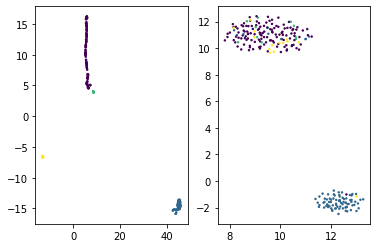

In [124]:
#select and cluster CFAV assemblies
CFAVassemblies=[]
for value in assembliesVsVir.index:
    if value in eveAssemblies and eveAssemblies[value][0]=="CFAV":
        CFAVassemblies.append(value)

CFAVindex=np.where(np.isin(assembliesVsVir.index, CFAVassemblies,assume_unique=True))[0]
ContigIdsCFAV=list(assembliesVsVir.index[CFAVindex])
X_embedded_CFAVvsVir = umap.UMAP(n_neighbors=50, min_dist=0.1, metric="euclidean").fit_transform(assembliesVsVirMatrix[CFAVindex,:])
clusteringCFAVsVir = DBSCAN(eps=1.5, min_samples=5).fit(X_embedded_CFAVvsVir).labels_        

#cluster the contigs that do not pass similarity threshold for core EVEs or CFAV. Basis for clustering is the similarity between contigs
CFAVAllvsAllindex=np.where(np.isin(AllvsAllassemblies.index, CFAVassemblies,assume_unique=True))[0]
ContigIdsCFAVAllvsAll=list(AllvsAllassemblies.index[CFAVAllvsAllindex])
X_embedded_CFAVallVsAll=umap.UMAP(n_neighbors=5, min_dist=0.1, metric="precomputed").fit_transform(AllvsAllassembliesMatrix[CFAVAllvsAllindex,:][:,CFAVAllvsAllindex])
clusteringnonCFAVallVsAll = DBSCAN(eps=1.5, min_samples=5).fit(X_embedded_CFAVallVsAll).labels_

colors=[]
for id in ContigIdsCFAVAllvsAll:
    if id in ContigIdsCFAV:
        colors.append(clusteringCFAVsVir[ContigIdsCFAV.index(id)])
    else:
        colors.append(-2)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(X_embedded_CFAVvsVir[:,0],X_embedded_CFAVvsVir[:,1], s=2, c=clusteringCFAVsVir)
ax2.scatter(X_embedded_CFAVallVsAll[:,0],X_embedded_CFAVallVsAll[:,1], s=2, c=colors)
#split of the sequences into 3/4 clusters is clear in left figure. However, umap is unable to fully resolve the similarity of sequenes based on e-values alone. 
#two thing are at play. Two clusters are identical in viral, but not flanking sequences. These give rise to two clusters in left figure, but one in right figure.
#Second, once two sequences have a long enough shared sequence, e-values becomes 0, the similarity of the remaining sequence becomes irrelevant.
#This is why the right figure is unable to resolve clearly distinct sequences in larger cluster.

In [61]:
#isolate longerst sequence in each cluster
files=[f for f in listdir(assembliesDir) if isfile(join(assembliesDir, f)) and splitext(f)[1]==".fasta"]

longestClusterSequence={} #key=cluster, #value=sequence

for contig in SeqIO.parse(wd+"allAssemblies.fasta", "fasta"):
    if contig.id in CFAVassemblies:
        cluster=clusteringCFAV[CFAVassemblies.index(contig.id)]
        if cluster not in longestClusterSequence:
            longestClusterSequence[cluster]=""
        if len(longestClusterSequence[cluster])<len(contig.seq):
                longestClusterSequence[cluster]=str(contig.seq)

with open(wd+"CFAV_assemblies.fasta","w") as output:
    for seq in longestClusterSequence:
        output.write(">cluster_"+str(seq)+"\n")
        output.write(longestClusterSequence[seq]+"\n")
    
with open(wd+"CFAVclusterIDs.tsv","w") as output:
    for i in range(0,len(CFAVindex)):
        output.write(str(clusteringCFAV[i])+"\t"+assembliesVsVir.index[CFAVindex[i]]+"\n")


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1737: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


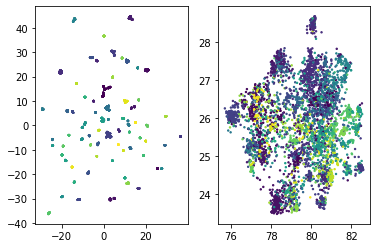

In [129]:
#select and cluster CFAV assemblies
EVEassemblies=[]
for value in assembliesVsVir.index:
    if value in eveAssemblies and eveAssemblies[value][0] in ["VIE4", "VIEW"]:
        EVEassemblies.append(value)

EVEindex=np.where(np.isin(assembliesVsVir.index, EVEassemblies,assume_unique=True))[0]
ContigIdsEVE=list(assembliesVsVir.index[EVEindex])
X_embedded_EVEvsVir = umap.UMAP(n_neighbors=50, min_dist=0.1, metric="euclidean").fit_transform(assembliesVsVirMatrix[EVEindex,:])
clusteringEVEvsVir = DBSCAN(eps=1.5, min_samples=5).fit(X_embedded_EVEvsVir).labels_        

#cluster the contigs that do not pass similarity threshold for core EVEs or CFAV. Basis for clustering is the similarity between contigs
EVEAllvsAllindex=np.where(np.isin(AllvsAllassemblies.index, EVEassemblies,assume_unique=True))[0]
ContigIdsEVEAllvsAll=list(AllvsAllassemblies.index[EVEAllvsAllindex])
X_embedded_EVEallVsAll=umap.UMAP(n_neighbors=30, min_dist=0.1, metric="precomputed").fit_transform(AllvsAllassembliesMatrix[EVEAllvsAllindex,:][:,EVEAllvsAllindex])
clusteringnonEVEallVsAll = DBSCAN(eps=1.5, min_samples=5).fit(X_embedded_EVEallVsAll).labels_

colors=[]
for id in ContigIdsEVEAllvsAll:
    if id in EVEassemblies:
        #colors.append(clusteringEVEvsVir[ContigIdsEVE.index(id)])
        colors.append(3)
    else:
        colors.append(-2)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(X_embedded_EVEvsVir[:,0],X_embedded_EVEvsVir[:,1], s=2, c=clusteringEVEvsVir)
ax2.scatter(X_embedded_EVEallVsAll[:,0],X_embedded_EVEallVsAll[:,1], s=2, c=colors)